# **PROBLEM STATEMENT**

Topic Modeling for Research Articles 2.0 Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process.


Given the abstracts for a set of research articles, predict the tags for each article included in the test set. Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics:

1. Computer Science

2. Mathematics

3. Physics

4. Statistics

List of possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]

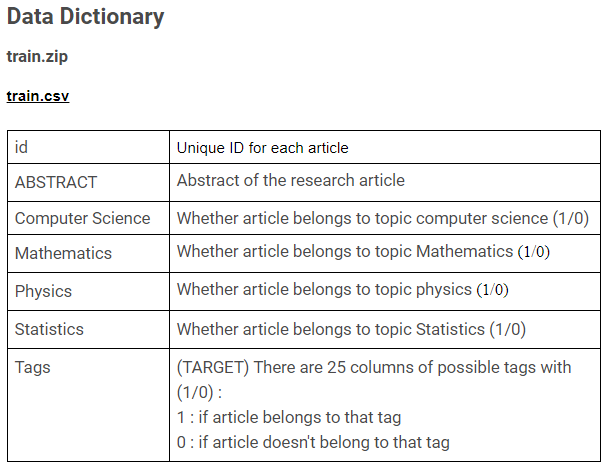

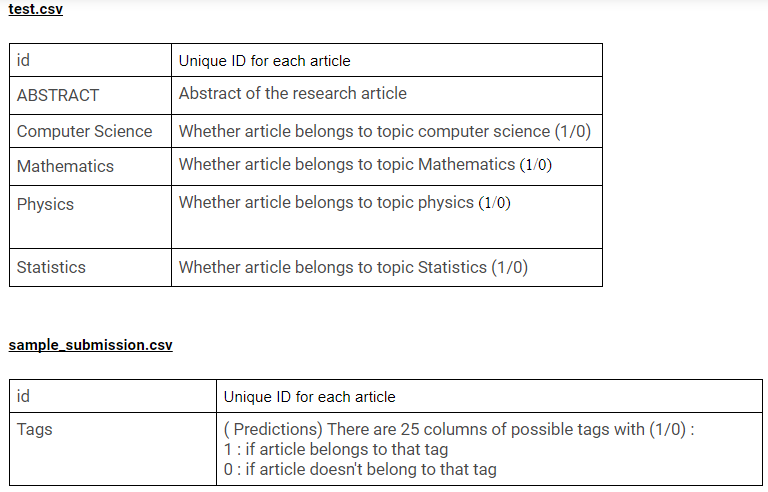

# **Importing Required Libraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from lightgbm import LGBMRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

# **Uploading the data**

In [1]:
from google.colab import files
files.upload()

Saving hacklive3_AV_Dataset.zip to hacklive3_AV_Dataset.zip


In [2]:
!unzip hacklive3_AV_Dataset.zip -d hacklive3_AV_Dataset

Archive:  hacklive3_AV_Dataset.zip
  inflating: hacklive3_AV_Dataset/hacklive3_AV_Dataset/glove_vectors  
  inflating: hacklive3_AV_Dataset/hacklive3_AV_Dataset/SampleSubmission_Uqu2HVA.csv  
  inflating: hacklive3_AV_Dataset/hacklive3_AV_Dataset/Tags.csv  
  inflating: hacklive3_AV_Dataset/hacklive3_AV_Dataset/Test.csv  
  inflating: hacklive3_AV_Dataset/hacklive3_AV_Dataset/Train.csv  


In [3]:
import os
os.chdir('/content/hacklive3_AV_Dataset/hacklive3_AV_Dataset')
cwd=os.getcwd()
print("cwd:",cwd)

cwd: /content/hacklive3_AV_Dataset/hacklive3_AV_Dataset


In [6]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission_Uqu2HVA.csv')
tags = pd.read_csv('Tags.csv')

# **EDA**

**1. Brief look at the dataset.**

In [7]:
train.head(3)
test.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0


In [8]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [9]:
len(TARGET_COLS)

25

# **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [10]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25

->->->| The dataset contains 5 features


# **3.Target Distribution**

In [11]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

# **4. Variable Datatypes**

Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

# **5. Null Values**

Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [13]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Systems and Control                             0.0
Differential Geometry                           0.0
ABSTRACT                                        0.0
Computer Science                                0.0
Mathematics                                     0.0
Physics                                         0.0
Statistics                                      0.0
Analysis of PDEs                                0.0
Applications                                    0.0
Artificial Intelligence                         0.0
Astrophysics of Galaxies                        0.0
Computation and Language                        0.0
Computer Vision and Pattern Recognition         0.0
Cosmology and Nongalactic Astrophysics          0.0
Data Structures and Algorithms                  0.0
Earth and Planetary Astrophysics                0.0
Superconductivity                               0.0
Fluid Dynamics                                  0.0
Information Theory                              0.0
Instrumentat

# **6. Unique values in each variable**

In [14]:
train.nunique()

id                                              14004
ABSTRACT                                        14004
Computer Science                                    2
Mathematics                                         2
Physics                                             2
Statistics                                          2
Analysis of PDEs                                    2
Applications                                        2
Artificial Intelligence                             2
Astrophysics of Galaxies                            2
Computation and Language                            2
Computer Vision and Pattern Recognition             2
Cosmology and Nongalactic Astrophysics              2
Data Structures and Algorithms                      2
Differential Geometry                               2
Earth and Planetary Astrophysics                    2
Fluid Dynamics                                      2
Information Theory                                  2
Instrumentation and Methods 

###ADDITIONAL DESCRIPTIVE EDA

In [15]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

Computer Science    5884
Physics             3856
Statistics          3794
Mathematics         2831
dtype: int64

In [16]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

# **VISUAL EDA THROUGH WORDCLOUDS**

In [17]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

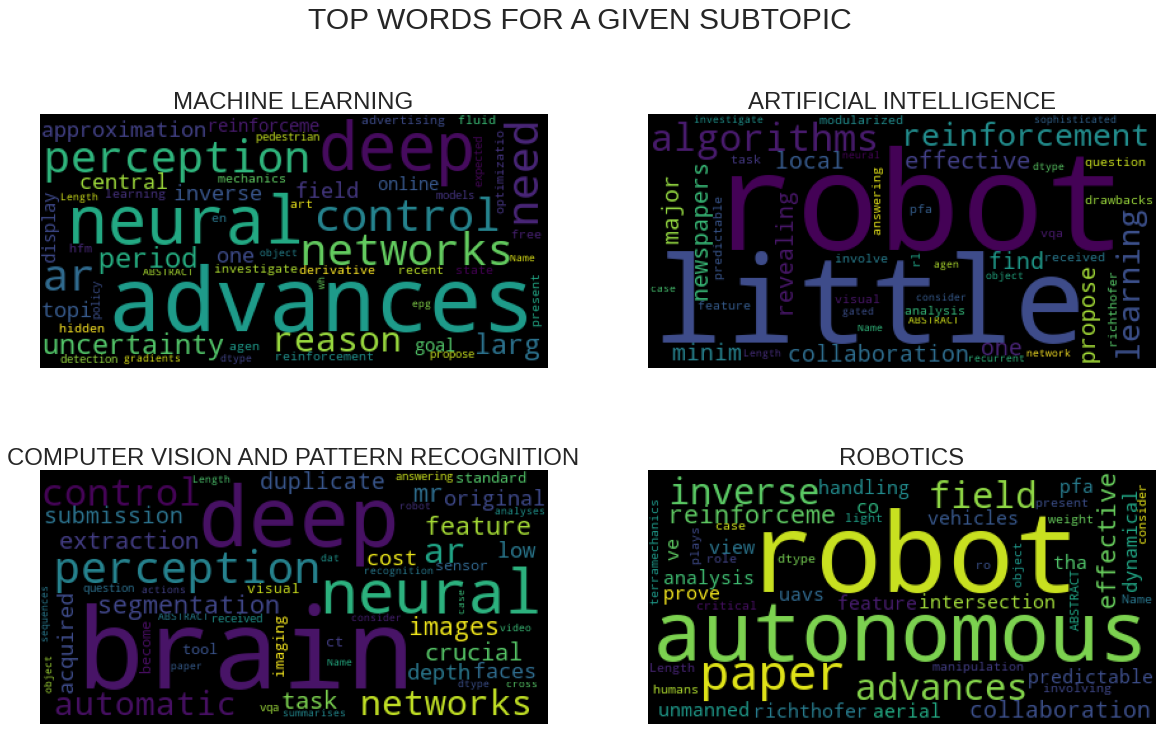

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

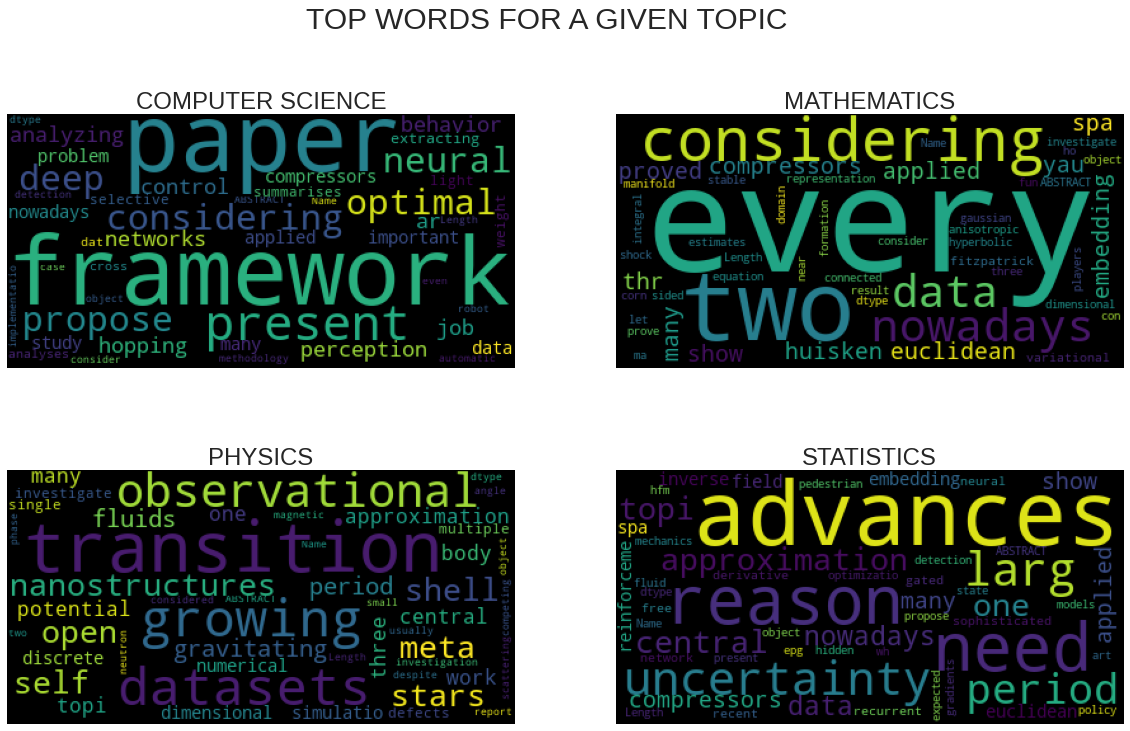

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

# **MODEL BUILDING**

##**Bag of Words Approach**

**Text:** Collection of Words

**Word:** Adds some kind of meaning to the sentence.

We make a bag containing all the words in our dataset.

**Features :** How many times is a particular word from the bag is present in our sentence ?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

**Count Vectorizer**

In [21]:
vec = CountVectorizer(max_features=10000)
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
vec.fit(combined)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [22]:
trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [23]:
trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

In [24]:
trn[TARGET_COLS]

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
6036,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5724,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
11745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13896,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6637,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# **One-vs-the-rest (OvR) multiclass/multilabel strategy**

Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. One advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. 

This is the most commonly used strategy for multiclass classification and is a fair default choice.

In [25]:
%%time

from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn[TARGET_COLS])

CPU times: user 396 ms, sys: 321 ms, total: 717 ms
Wall time: 21.1 s


In [26]:
val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

0.623196768609348

In [34]:
preds_test = clf.predict(tst_abs)

In [64]:
def download_preds(preds_test, file_name = 'submission.csv'):

  ## 1. Setting the target column with our obtained predictions


  ss[TARGET_COLS] = preds_test
  ## 2. Saving our predictions to a csv file
  ss['ABSTRACT']=test['ABSTRACT']
  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

In [65]:
download_preds(preds_test, 'submission_NLP_count.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
ss_pred = ss[[c for c in ss if c not in TARGET_COLS] 
        + [c for c in TARGET_COLS if c in ss]]

In [67]:
ss_pred = pd.read_csv('submission_NLP_count.csv')

In [69]:
ss_pred.head(10)

,id,ABSTRACT,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,17934,"this large-scale study, consisting of 24.5 mil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16071,we present a stability analysis of the plane c...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16870,we construct finite time blow-up solutions to ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4878,with a recent advancements inside artificial i...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,4612,model-based optimization methods and discrimin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,18718,inside a present work the new controller calle...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,12389,we study a problem of community detection insi...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4835,graphene nanoribbons (gnrs) are ultra-narrow s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [79]:
ss_pred.iloc[[4,5]]

,id,ABSTRACT,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
4,10496,planetary nebulae (pne) constitute an importan...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4878,with a recent advancements inside artificial i...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Testing our Results by taking few sample records**

In [77]:
ss_pred['ABSTRACT'][4]

'planetary nebulae (pne) constitute an important tool to study a chemical evolution of a milky way and other galaxies, probing a nucleosynthesis processes, abundance gradients and a chemical enrichment of a interstellar medium. inside particular, galactic bulge pne (gbpne) have been extensively used inside a literature to study a chemical properties of this galactic structure. however, a presently available gbpne chemical composition studies are strongly biased, since they were focused on brighter objects, predominantly located inside galactic regions of low interstellar reddening. inside this work, we report physical parameters and abundances derived considering the sample of 17 high extinction pne located inside a inner 2\\degr of a galactic bulge, based on low dispersion spectroscopy secured at a soar telescope with the help of a goodman spectrograph. a new data allow us to extend our database including faint objects, providing chemical compositions considering pne located inside th

In [78]:
ss_pred['ABSTRACT'][5]

"with a recent advancements inside artificial intelligence (ai), various organizations and individuals started debating about a progress of ai as the blessing or the curse considering a future of a society. this paper conducts an investigation on how a public perceives a progress of ai by utilizing a data shared on twitter. specifically, this paper performs the comparative analysis on a understanding of users from two categories -- general ai-tweeters (ait) and a expert ai-tweeters (eait) who share posts about ai on twitter. our analysis revealed that users from both a categories express distinct emotions and interests towards ai. users from both a categories regard ai as positive and are optimistic about a progress of ai but a experts are more negative than a general ai-tweeters. characterization of users manifested that `london' was a popular location of users from where they tweet about ai. tweets posted by ait are highly retweeted than posts made by eait that reveals greater diffus

# **Tfidf Vectorizer Approach**

TF-IDF = Term-Frequency * Inverse Document Frequency

Is another approach apart from BOW approach which can be used as an NLP method

Term-Frequency = (Frequency of the word in the sentence) / (Total number of words in the sentence)

Inverse Document Frequency = (Total number of sentences)/(Number of sentences containing the word)

**We will use the below sklearns model for TFIDF Vectorization**

In [80]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

0.6300845429893125

In [81]:
preds_test = clf.predict(tst_abs)
download_preds(preds_test, 'Submission_NLP_tfidf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
ss_pred = ss[[c for c in ss if c not in TARGET_COLS] 
        + [c for c in TARGET_COLS if c in ss]]

In [84]:
ss_pred = pd.read_csv('Submission_NLP_tfidf.csv')

In [85]:
ss_pred.head(10)

,id,ABSTRACT,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,Fluid Dynamics,Information Theory,Instrumentation and Methods for Astrophysics,Machine Learning,Materials Science,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,17934,"this large-scale study, consisting of 24.5 mil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,16071,we present a stability analysis of the plane c...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16870,we construct finite time blow-up solutions to ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4878,with a recent advancements inside artificial i...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,4612,model-based optimization methods and discrimin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,18718,inside a present work the new controller calle...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,12389,we study a problem of community detection insi...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4835,graphene nanoribbons (gnrs) are ultra-narrow s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# **Optimal Threshold for F1-score**

In [89]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

In [95]:
val_preds = clf.predict_proba(val_abs)

best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)
#print('best_thresholds:',best_thresholds)
for i, thresh in enumerate(best_thresholds):
  #print('i:',i)
  #print('thresh:',thresh)
  #print('val_preds[:, i]',val_preds[:, i])
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
  #print('val_preds[:, i] > thresh',val_preds[:, i] > thresh)
  #print('val_preds[:, i]',val_preds[:, i])

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.6872952311612669

In [96]:
preds_test = clf.predict_proba(tst_abs)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'submission_NLP_tfidf_threshold_optimized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
TOPIC_COLS

['Computer Science', 'Mathematics', 'Physics', 'Statistics']

**Combining Topics**

In [99]:
trn_abs.shape

(11203, 10000)

In [101]:
vec = CountVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))
#_ = vec.fit(preprocessed_abstract_train + preprocessed_abstract_test) 

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])
print(trn_abs.shape, val_abs.shape, tst_abs.shape)

trn2 = np.hstack((trn_abs.toarray(), trn[TOPIC_COLS]))
val2 = np.hstack((val_abs.toarray(), val[TOPIC_COLS]))
tst2 = np.hstack((tst_abs.toarray(), test[TOPIC_COLS]))

print(trn2.shape, val2.shape, tst2.shape)

(11203, 10000) (2801, 10000) (6002, 10000)
(11203, 10004) (2801, 10004) (6002, 10004)


In [102]:
from scipy.sparse import csr_matrix

trn2 = csr_matrix(trn2.astype('int16'))
val2 = csr_matrix(val2.astype('int16'))
tst2 = csr_matrix(tst2.astype('int16'))

In [104]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_  = clf.fit(trn2, trn[TARGET_COLS])

val_preds = clf.predict_proba(val2)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.7119645494830134

In [ ]:
preds_test = clf.predict_proba(tst2)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'TFIDF_NLP_count_added_topics.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TEXT CLEANING OF ABSTRACT DATA**

In [105]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [106]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [107]:
train['ABSTRACT'].head(5)

0    a ever-growing datasets inside observational a...
1    we propose the framework considering optimal $...
2    nanostructures with open shell transition meta...
3    stars are self-gravitating fluids inside which...
4    deep neural perception and control networks ar...
Name: ABSTRACT, dtype: object

In [109]:
print("printing some random abstracts")
print(0, train['ABSTRACT'].values[0])
print(1, train['ABSTRACT'].values[1])

printing some random abstracts
0 a ever-growing datasets inside observational astronomy have challenged scientists inside many aspects, including an efficient and interactive data exploration and visualization. many tools have been developed to confront this challenge. however, they usually focus on displaying a actual images or focus on visualizing patterns within catalogs inside the predefined way. inside this paper we introduce vizic, the python visualization library that builds a connection between images and catalogs through an interactive map of a sky region. vizic visualizes catalog data over the custom background canvas with the help of a shape, size and orientation of each object inside a catalog. a displayed objects inside a map are highly interactive and customizable comparing to those inside a images. these objects should be filtered by or colored by their properties, such as redshift and magnitude. they also should be sub-selected with the help of the lasso-like tool consi

**AFTER CLEANSING**

In [110]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [111]:
preprocessed_abstract_train = preprocess_text(train['ABSTRACT'].values)

100%|██████████| 14004/14004 [00:05<00:00, 2667.67it/s]


In [112]:
preprocessed_abstract_test = preprocess_text(test['ABSTRACT'].values)

100%|██████████| 6002/6002 [00:02<00:00, 2708.01it/s]


In [116]:
print("printing the cleansed ABSTRACT data")
print("--------------****************---------------")
print(preprocessed_abstract_train[0])
print(preprocessed_abstract_train[1])

printing the cleansed ABSTRACT data
--------------****************---------------
ever growing datasets inside observational astronomy challenged scientists inside many aspects including efficient interactive data exploration visualization many tools developed confront challenge however usually focus displaying actual images focus visualizing patterns within catalogs inside predefined way inside paper introduce vizic python visualization library builds connection images catalogs interactive map sky region vizic visualizes catalog data custom background canvas help shape size orientation object inside catalog displayed objects inside map highly interactive customizable comparing inside images objects filtered colored properties redshift magnitude also sub selected help lasso like tool considering analysis help standard python functions jupyter notebook furthermore vizic allows custom overlays appended dynamically top sky map initially implemented several overlays namely voronoi delaunay

# **APPLYING TFIDF Vectorization on Cleansed Data**

In [119]:
vec = CountVectorizer(max_features=10000)
#_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))
_ = vec.fit(preprocessed_abstract_train + preprocessed_abstract_test) 

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])
print(trn_abs.shape, val_abs.shape, tst_abs.shape)

trn3 = np.hstack((trn_abs.toarray(), trn[TOPIC_COLS]))
val3 = np.hstack((val_abs.toarray(), val[TOPIC_COLS]))
tst3 = np.hstack((tst_abs.toarray(), test[TOPIC_COLS]))

print(trn2.shape, val2.shape, tst2.shape)

(11203, 10000) (2801, 10000) (6002, 10000)
(11203, 10004) (2801, 10004) (6002, 10004)


In [120]:
from scipy.sparse import csr_matrix

trn3 = csr_matrix(trn3.astype('int16'))
val3 = csr_matrix(val3.astype('int16'))
tst3 = csr_matrix(tst3.astype('int16'))

In [122]:
clf = OneVsRestClassifier(LogisticRegression(C = 0.1, n_jobs=-1))
_  = clf.fit(trn3, trn[TARGET_COLS])

val_preds = clf.predict_proba(val3)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.7449351956713226

In [ ]:
preds_test = clf.predict_proba(tst2)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'TFIDF_NLP_with_Cleansed_data.csv')

# **Final Summary of all the Approaches**

In [152]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter","f1_score"]
x.add_row(["BOW Approach", 'C: 10', 0.623])
x.add_row(["TFIDF Approach", 'C: 10',0.630])
x.add_row(["TFIDF Approach (with cleansing)", 'C: 0.1', 0.744])
print(x)

+---------------------------------+-----------------+----------+
|              Model              | Hyper Parameter | f1_score |
+---------------------------------+-----------------+----------+
|           BOW Approach          |      C: 10      |  0.623   |
|          TFIDF Approach         |      C: 10      |   0.63   |
| TFIDF Approach (with cleansing) |      C: 0.1     |  0.744   |
+---------------------------------+-----------------+----------+
